# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Import libraries:

In [33]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
import time
from scipy.stats import mode

%matplotlib inline

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


In [34]:
data_test = pd.read_csv('./data/Higgs_test.csv')
data_train = pd.read_csv('./data/Higgs_train.csv')
ytest = data_test[' class']
ytrain = data_train[' class']
Xtest = data_test.copy().drop(' class', 1)
Xtrain = data_train.copy().drop(' class', 1)
data_train.describe()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978640,-0.014242,-0.018940,1.005780,0.002530,0.980407,0.025035,-0.007136,0.994617,0.988662,...,0.003368,1.008448,1.038472,1.027210,1.054741,1.023142,0.958457,1.033427,0.960473,0.524600
std,0.547021,1.011918,0.997988,0.591891,1.003353,0.463663,1.002021,1.014606,1.030335,0.476439,...,1.008882,1.401732,0.619626,0.353993,0.173192,0.427188,0.495710,0.352967,0.306009,0.499444
min,0.275063,-2.411601,-1.741953,0.010021,-1.742062,0.170481,-2.920213,-1.741237,0.000000,0.197668,...,-1.742136,0.000000,0.151059,0.442752,0.338730,0.370879,0.079460,0.412750,0.452206,0.000000
25%,0.586819,-0.763889,-0.877757,0.581321,-0.869805,0.676038,-0.658776,-0.884866,0.000000,0.665526,...,-0.869398,0.000000,0.798538,0.849911,0.985864,0.767558,0.671749,0.826300,0.772501,0.000000
50%,0.845502,-0.009307,-0.016055,0.903459,0.001296,0.890926,0.049486,-0.023503,1.086538,0.891397,...,-0.004703,0.000000,0.898054,0.957433,0.989756,0.922169,0.868331,0.951904,0.877457,1.000000
75%,1.219481,0.725066,0.836731,1.303024,0.865695,1.163526,0.715911,0.893814,2.173076,1.195013,...,0.858842,3.101961,1.032753,1.091803,1.031178,1.155744,1.122398,1.143154,1.061552,1.000000
max,5.325748,2.427076,1.742681,6.259064,1.742935,4.185626,2.962743,1.741454,2.173076,4.800826,...,1.743372,3.101961,10.642818,5.735043,3.938281,6.220779,5.075656,4.324610,3.496444,1.000000


In [35]:
# Using Gridsearch to find optimal tree depth with 5-fold cross-validation
from sklearn import grid_search
parameters = {'max_depth':list(range(2,11))}
dtc_gs_mod = grid_search.GridSearchCV(DecisionTreeClassifier(), 
                                   parameters, 
                                   cv = 5,
                                   n_jobs=4)
dtc_gs_mod.fit(Xtrain, ytrain)
print (dtc_gs_mod.best_score_, dtc_gs_mod.best_params_) 
max_tree_depth = dtc_gs_mod.best_params_['max_depth']

0.6392 {'max_depth': 5}


## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets. 

- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

In [36]:
# Baseline Decision Tree performance with no limit on tree depth
dtc_mod1 = DecisionTreeClassifier()
dtc_mod1.fit(Xtrain, ytrain)
print ('Baseline Decision Tree performance with no limit on tree depth')
print ('Train Accuracy: {}'.format(accuracy_score(ytrain, dtc_mod1.predict(Xtrain))))
print ('Test Accuracy:  {}'.format(accuracy_score(ytest, dtc_mod1.predict(Xtest))))

# Baseline Decision Tree performance with tree depth set to max_tree_depth
dtc_mod2 = DecisionTreeClassifier(max_depth = max_tree_depth)
dtc_mod2.fit(Xtrain, ytrain)
print ('\nDecision Tree performance with tree depth {}'.format(max_tree_depth))
print ('Train Accuracy: {}'.format(accuracy_score(ytrain, dtc_mod2.predict(Xtrain))))
print ('Test Accuracy:  {}'.format(accuracy_score(ytest, dtc_mod2.predict(Xtest))))


Baseline Decision Tree performance with no limit on tree depth
Train Accuracy: 1.0
Test Accuracy:  0.6062

Decision Tree performance with tree depth 5
Train Accuracy: 0.682
Test Accuracy:  0.6454


In [37]:
def create_train_sets(Xtrain, num_trees, drop_prob):
#  Create b training sets
#  For each training set, predictors are randomly zeroed out
#  with probability 1.0 - drop_prob
    B = {}
    for tree in range(num_trees):
        B[tree + 1] = Xtrain.copy()
        for pred in list(B[tree + 1]):
            # Iterate through predictors
            if ( np.random.uniform() > 1.0 - drop_prob ):
                # Zero out predictor column values if above 
                # probability threshold, 1.0 - drop_prob
                B[tree + 1][pred] = 0
    return B


def ensemble_classifier (B, y, max_tree_depth):
    # Fit Decision Tree Classifiers to the B training sets
    H = {}
    for key in B:
        dtc_mod = DecisionTreeClassifier(max_depth = max_tree_depth)
        H[key] = dtc_mod.fit(B[key], y)
    # Return dict of B Decision Tree Classifiers
    return H

def pred_ensemble_classifier(x, e):
    # Take the majority vote of the B decision tree models
    a = np.array([])
    # Make predictions for each classifier
    for key in e:
        p = e[key].predict(x)
        if (key != 1):
            a = np.append(a,p)
        else:
            a = p
    # Dataframe containing predictions of all models (columnwise)
    aa = {}
    aa = a.reshape(len(x),len(e))
    # Take majority vote via 'mode' fcn, ties are set to 0 by mode
    return mode(aa, axis = 1)[0]

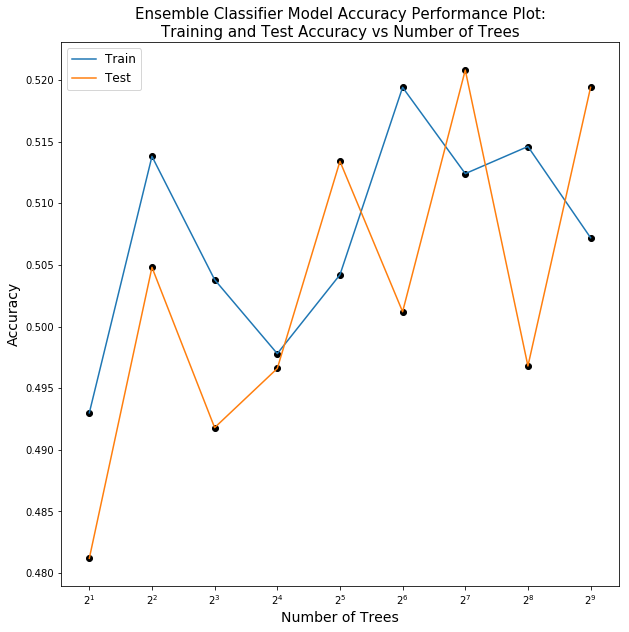

In [38]:
# Apply the dropout procedure with  p = 0.5 
# for different number of trees (say  2,4,8,16,…,256),
# and evaluate the training and test accuracy of the combined classifier. 

trees = list(np.power(2, range(1, 10)))  # Binary range of trees
ensemble_mod_acc = {'test':[], 'train': [], 'train_one_tree': []}
for tree in trees:
    # Create Xtrain sets
    Xtrain_set = {}
    Xtrain_set = create_train_sets(Xtrain, num_trees = tree, drop_prob = 0.5)
    # Monitor time to fit
    start = time.time()
    # Fit DTC models to the train sets
    e = ensemble_classifier(Xtrain_set, ytrain, max_tree_depth)
    totalTime = time.time() - start
    train_pred = pred_ensemble_classifier(Xtrain, e)
    test_pred  = pred_ensemble_classifier(Xtest, e)
    ensemble_mod_acc['train'].append(accuracy_score(ytrain, train_pred))
    ensemble_mod_acc['test'].append(accuracy_score(ytest,  test_pred))

fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xscale('log', basex=2)

ax.plot(trees, ensemble_mod_acc['train'], label='Train')
ax.plot(trees, ensemble_mod_acc['test'], label='Test')
ax.scatter(trees, ensemble_mod_acc['train'], c='k')
ax.scatter(trees, ensemble_mod_acc['test'], c='k')
ax.axis('tight')
ax.set_xlabel('Number of Trees', fontsize = 14)
ax.set_ylabel('Accuracy',   fontsize = 14)
ax.legend(fontsize = 12)
ax.set_title("Ensemble Classifier Model Accuracy Performance Plot:\nTraining and Test Accuracy vs Number of Trees",
         fontsize = 15)


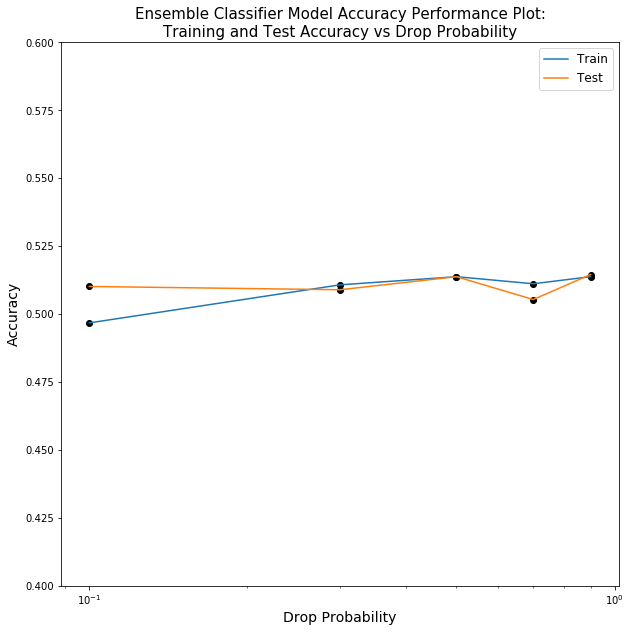

In [39]:
# Fix the number of trees to 64 and apply the dropout procedure with 
# different dropout rates  p=0.1,0.3,0.5,0.7,0.9
trees = 64  
drop_probs = [0.1, 0.3 , 0.5, 0.7, 0.9]
ensemble_mod_acc = {'test':[], 'train': []}
for drop_prob in drop_probs:
    # Create Xtrain sets
    Xtrain_set = {}
    Xtrain_set = create_train_sets(Xtrain, num_trees = trees, drop_prob = drop_prob)
    # Monitor time to fit
    start = time.time()
    # Fit DTC models to the train sets
    e = ensemble_classifier(Xtrain_set, ytrain, max_tree_depth)
    totalTime = time.time() - start
    train_pred = pred_ensemble_classifier(Xtrain, e)
    test_pred  = pred_ensemble_classifier(Xtest, e)
    ensemble_mod_acc['train'].append(accuracy_score(ytrain, train_pred))
    ensemble_mod_acc['test'].append(accuracy_score(ytest,  test_pred))


plt.figure(figsize = (10, 10))
plt.semilogx(drop_probs, ensemble_mod_acc['train'], label='Train')
plt.semilogx(drop_probs, ensemble_mod_acc['test'], label='Test')
plt.scatter(drop_probs, ensemble_mod_acc['train'], c='k')
plt.scatter(drop_probs, ensemble_mod_acc['test'], c='k')
plt.axis('tight')
plt.xlabel('Drop Probability', fontsize = 14)
plt.ylabel('Accuracy',   fontsize = 14)
plt.legend(fontsize = 12)
plt.title("Ensemble Classifier Model Accuracy Performance Plot:\nTraining and Test Accuracy vs Drop Probability",
         fontsize = 15)
plt.ylim(ymin = 0.4, ymax = .6)
plt.show()

In [40]:
# Apply 5-fold cross-validation to choose the optimal combination of the dropout rate 
# and number of trees. 
# You may need to restrict the max number of trees.]
from sklearn.cross_validation import KFold

n = data_train.shape[0]
trees = list(np.power(2, range(1, 9)))  # Binary range of trees
print("TREES ARE:")
print(trees)
drop_probs = [0.1, 0.3 , 0.5, 0.7, 0.9]


df_scores = pd.DataFrame(columns=['p', 'trees', 'accuracy'])
results = []
for drop_prob in drop_probs:
    for tree in trees:
        scores = []
        for f_xtrain, f_xtest in KFold(n, n_folds=10, shuffle=False, random_state=11):
            mini_Xtrain_set = {}
            mini_xtrain = Xtrain.iloc[f_xtrain]
            mini_xtest =  Xtest.iloc[f_xtest]
            mini_ytrain = ytrain.iloc[f_xtrain]
            mini_ytest =  ytest.iloc[f_xtest]
            # Create Xtrain sets
            mini_Xtrain_set = create_train_sets(mini_xtrain, 
                                                num_trees = tree, 
                                                drop_prob = drop_prob)
            # Fit DTC models to the train sets
            e = ensemble_classifier(mini_Xtrain_set, mini_ytrain, max_tree_depth)
            train_pred = pred_ensemble_classifier(mini_xtrain, e)
            score = accuracy_score(mini_ytrain, train_pred)
            scores.append(score)
        results.append([drop_prob, tree, np.mean(scores, axis=0)])
        print (drop_prob, tree, np.mean(scores, axis=0), end="\r")  

        # Output optimal combination of the dropout rate and number of trees
df_scores = pd.DataFrame(results, columns=['drop_prob', 'trees', 'train_acc'])
df_scores.ix[df_test['train_acc'].idxmax()]


TREES ARE:
[2, 4, 8, 16, 32, 64, 128, 256]


/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


drop_prob    0.300000
trees        4.000000
train_acc    0.502533
Name: 9, dtype: float64

In [41]:
df_scores.sort_values('train_acc', ascending=False, inplace=True)
df_scores.head()

,drop_prob,trees,train_acc
38,0.9,128,0.517311
22,0.5,128,0.516867
39,0.9,256,0.516311
37,0.9,64,0.515622
31,0.7,256,0.515244


#### Q: Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.

Training and test accuracy do not improve with an increase in the number of trees as the plot above shows.  Accuracy for both remains relatively constant at 0.5, which is considered subpar performance, i.e., this model exhibits high bias.  The model also exhibits very low variance in that test accuracy is virtually identical to train accuracy regardless of the number of trees trained on.  This is the result of using multiple decision tree classifiers to create a majority vote based prediction.


#### Q: Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.

Similar results were observed with dropout rate, where performance is almost identical for both training and test sets at approximately 0.5, regardless of the dropout rate. However, it's worth noting that the number of trees is set to 64 here, so that may be the primary effect of reducing variance as explained above.

#### Q: How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1? [hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

The best performance was just 0.52 -- barely better than a coin flip, and slightly worse than guessing "1" every time (the percent of 1 values in the dataset is just over 0.52). This performed poorly compared to the single decision tree with a score of 0.65 on the test data.


## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  





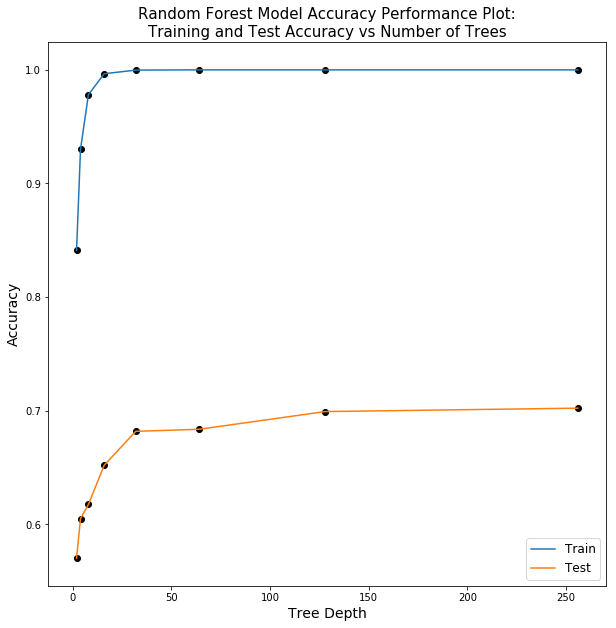

In [42]:
# Fit random forest models to the training set for different number of trees 
# (say  2,4,8,16,…,256), and evaluate the training and test accuracies of the models. 

trees = list(np.power(2, range(1, 9)))  # Binary range of trees
rf_mod_acc = {'test':[], 'train': []}
for tree in trees:
    # Create Xtrain sets
    num_pred = np.int(np.sqrt(len(list(Xtrain))))
    rf_mod = RandomForestClassifier(n_estimators = tree)
    # Fit RF model to the train set
    rf_mod.fit(Xtrain, ytrain)
    rf_mod_acc['train'].append(rf_mod.score(Xtrain, ytrain))
    rf_mod_acc['test'].append(rf_mod.score(Xtest, ytest))


plt.figure(figsize = (10, 10))
plt.plot(trees, rf_mod_acc['train'], label='Train')
plt.plot(trees, rf_mod_acc['test'], label='Test')
plt.scatter(trees, rf_mod_acc['train'], c='k')
plt.scatter(trees, rf_mod_acc['test'], c='k')
plt.axis('tight')
plt.xlabel('Tree Depth', fontsize = 14)
plt.ylabel('Accuracy',   fontsize = 14)
plt.legend(fontsize = 12)
plt.title("Random Forest Model Accuracy Performance Plot:\nTraining and Test Accuracy vs Number of Trees",
         fontsize = 15)
plt.show()

In [43]:
# Using Gridsearch to find optimal tree depth with 5-fold cross-validation
# Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to 
# choose the optimal value for the number of predictors.
parameters = {'max_features':[2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
rf_gs_mod = grid_search.GridSearchCV(RandomForestClassifier(n_estimators = 100), 
                                   parameters, 
                                   cv = 5,
                                   n_jobs=4)
rf_gs_mod.fit(Xtrain, ytrain)
print (rf_gs_mod.best_score_, rf_gs_mod.best_params_) 


0.6894 {'max_features': 6}


#### Q: How does a random forest approach differ from the dropout procedure described in Question 2?

For each dropout model, multiple decision trees were created, each with its own random subset of predictors.  The random forest approach differs from the dropout model in that a random subset of features is selected at each candidate split during the random forest learning process. 

#### Q: Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? 

Yes, in that test accuracy monotonically increases, with diminishing returns, as it approaches an asymptotic limit of ~0.7 as the number of trees in the random forest model is increased.  

#### Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier.

Training set accuracy quickly approaches and remains at 1.0 as the number of trees is increased.  Test set accuracy also jumps up quickly, though at a less rapid rate than the training set, to its peak value of 0.7, as the number of trees increasing.  While the train set is perfectly fit, overfitting doesn't occur because test performance keeps increasing as described.

While there is a larger gap between training and test performance, bias is lower for both training (perfect prediction is achieved fairly quickly) and test (performs better than the dropout and single decision tree models).  Model stability (variance) is improved in that test performance never decreases as more trees are added.


#### Q: How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?

It performs MUCH better, with an accuracy score of 0.69. The dropout trees in problem 2 did not perform much better than 50/50, with the best one having an accuracy score of 0.52

## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 



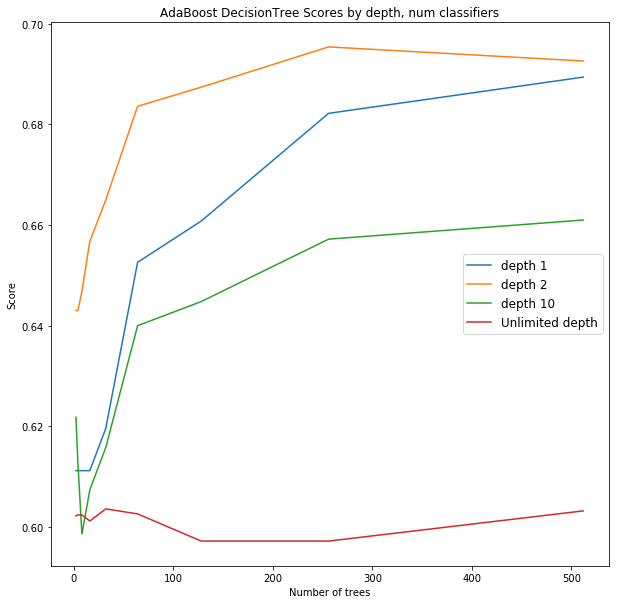

In [44]:
depths = [1, 2, 10, None]
tree_nums = [2,4,8,16,32,64,128,256, 512]

scores = []
for depth in depths:
    depth_scores = []
    for tree_num in tree_nums:
        dtc = DecisionTreeClassifier(max_depth=depth)
        ada = AdaBoostClassifier(dtc, learning_rate=0.05, n_estimators=tree_num)
        ada.fit(Xtrain, ytrain)
        depth_scores.append(ada.score(Xtest, ytest))
    scores.append(depth_scores)

plt.figure(figsize = (10, 10))
plt.title('AdaBoost DecisionTree Scores by depth, num classifiers')
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.plot(tree_nums, scores[0], label='depth 1')
plt.plot(tree_nums, scores[1], label='depth 2')
plt.plot(tree_nums, scores[2], label='depth 10')
plt.plot(tree_nums, scores[3], label='Unlimited depth')
plt.legend(fontsize = 12)
plt.show()

In [45]:
from sklearn import grid_search

parameters = {'base_estimator__max_depth': depths, 'n_estimators': tree_nums}
dtc = DecisionTreeClassifier()
abc = AdaBoostClassifier(base_estimator=dtc, learning_rate=0.05)
dtc_gs = grid_search.GridSearchCV(abc, param_grid = parameters, cv = 5, n_jobs=4)
dtc_gs.fit(Xtrain, ytrain)
print (dtc_gs.best_score_, dtc_gs.best_params_) 


0.685 {'base_estimator__max_depth': 2, 'n_estimators': 256}


{'test': [0.60780000000000001, 0.59560000000000002, 0.60219999999999996, 0.60119999999999996, 0.59560000000000002, 0.60099999999999998, 0.60319999999999996, 0.60640000000000005], 'train': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


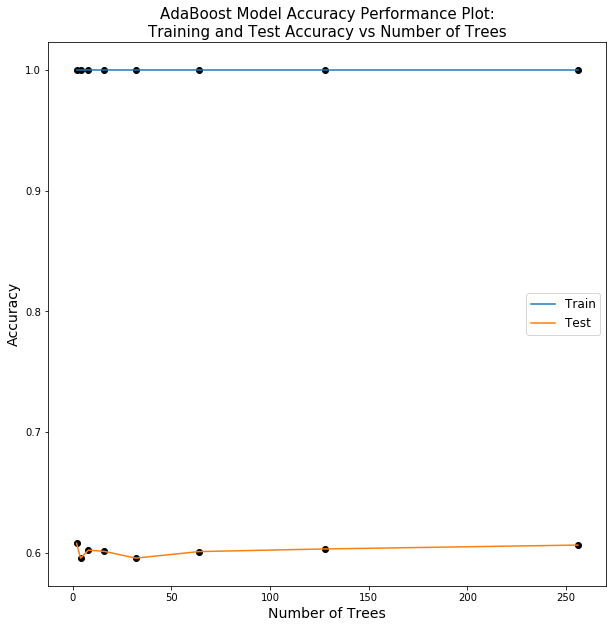

In [46]:
# Apply the AdaBoost algorithm to fit an ensemble of decision trees. 
# Make a similar plot of the test accuracies as a function of number of trees 
#(say  2,4,8,16,…,256).

trees = list(np.power(2, range(1, 9)))  # Binary range of trees
ada_mod_acc = {'test':[], 'train': []}
for tree in trees:
    ada_mod = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),
                                 n_estimators = tree,
                                 learning_rate = 0.05)
    ada_mod.fit(Xtrain, ytrain)
    ada_mod_acc['train'].append(ada_mod.score(Xtrain, ytrain))
    ada_mod_acc['test'].append(ada_mod.score(Xtest, ytest))

print(ada_mod_acc)
plt.figure(figsize = (10, 10))
plt.plot(trees, ada_mod_acc['train'], label='Train')
plt.plot(trees, ada_mod_acc['test'], label='Test')
plt.scatter(trees, ada_mod_acc['train'], c='k')
plt.scatter(trees, ada_mod_acc['test'], c='k')
plt.axis('tight')
plt.xlabel('Number of Trees', fontsize = 14)
plt.ylabel('Accuracy',   fontsize = 14)
plt.legend(fontsize = 12)
plt.title("AdaBoost Model Accuracy Performance Plot:\nTraining and Test Accuracy vs Number of Trees",
         fontsize = 15)
plt.show()

In [47]:
# Apply 5-fold cross-validation to choose the optimal number of trees  B
# for the ensemble and the optimal tree depth for the base learners.
# Observation: GS will select the largest number of trees specified as the optima
parameters = {'n_estimators':list(np.power(2, range(2, 8))), 
              'base_estimator__max_depth': list(range(4, 10, 2)), 
              'learning_rate':[0.05]}
ada_gs_mod = grid_search.GridSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier()), 
                                   parameters, 
                                   cv = 5,
                                   n_jobs=4)

ada_gs_mod.fit(Xtrain, ytrain)
print (ada_gs_mod.best_score_, ada_gs_mod.best_params_) 


0.6772 {'base_estimator__max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 64}


#### Q: How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.

The train performance was consistently 1.0 -- all of the samples were fit perfectly. This is because Boosting is essentially designed to fit the data as efficiently as possible by selecting outliers and modifying the model to fit them more closely with each pass. 
The test scores stayed constant around 0.60, which is worse than the scores for the random forest in part 3. This is probably due to overfitting of the data.

#### Q: How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.

The tree depth had a huge impact on the test performance. There was a clear "best depth" at a depth of 2, while the depths on either side performed worse than a depth of 2. The unlimited depth performed much worse, indicating overfitting. Using an unlimited tree depth with boosting is not recommended.


#### Q: How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4?

The "best" ensemble classifier had a score of 0.68, just less than the best score in 3.4 of 0.69. These are close enough that the difference may not be significant.

## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.



In [55]:
import base64
models = np.load('models.npy', encoding='latin1')


/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Score by simple vote:
0.6646

Best performing model:
Score on train: 
0.6208
Score on test
0.6072

Weighted vote score
0.6658
Removing worst trees from weighted vote


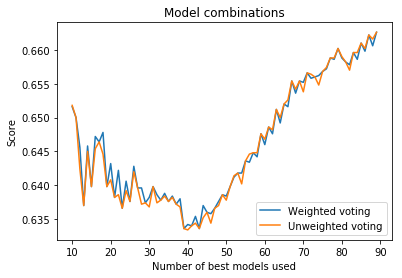

In [56]:
print("Score by simple vote:")
predictions = np.array([model.predict(Xtest) for model in models])
numPredictions = len(predictions.T)
vote_predictions = [np.round(np.mean(predictions.T[i])) for i in range(numPredictions)]
vote_score = accuracy_score(vote_predictions, ytest)
print(vote_score)

# Get a list of model train scores
scores = [model.score(Xtrain, ytrain) for model in models]

print("\nBest performing model:")
print("Score on train: ")
#print(scores[bestModelIdx])
bestModelIdx = np.argmax(scores)
print(scores[bestModelIdx])
print("Score on test")
bestModel = models[bestModelIdx]
print(bestModel.score(Xtest, ytest))

print("\nWeighted vote score")
# Weight votes by performance on the training set
weighted_votes = [np.round(np.average(predictions.T[i], weights=scores)) for i in range(numPredictions)]
weighted_vote_score = accuracy_score(weighted_votes, ytest)
print(weighted_vote_score)


# Remove the worst-performing trees and do a weighted vote
print("Removing worst trees from weighted vote")
def use_best_predictors(num_best=100, weighted=True):
    best_trees = np.argpartition(scores, -num_best)[-num_best:]
    best_predictions = np.array([predictions[i] for i in best_trees])
    best_scores = np.array([scores[i] for i in best_trees])
    numPredictions = len(best_predictions.T)
    if weighted:
        best_weighted_votes = [np.round(np.average(best_predictions.T[i], weights=best_scores)) for i in range(numPredictions)]
    else:
        best_weighted_votes = [np.round(np.average(best_predictions.T[i])) for i in range(numPredictions)]
    return accuracy_score(best_weighted_votes, ytest)


# Look at the weighted vote over only the best models
best_scores = {'weighted':[], 'unweighted':[]}
for i in range(10, 90):
    best_scores['weighted'].append(use_best_predictors(i, weighted=True))
    best_scores['unweighted'].append(use_best_predictors(i, weighted=False))
    
plt.title("Model combinations")
plt.xlabel("Number of best models used")
plt.ylabel("Score")
plt.plot(list(range(10, 90)), best_scores['weighted'], label='Weighted voting')
plt.plot(list(range(10, 90)), best_scores['unweighted'], label='Unweighted voting')
plt.legend(loc = 'lower right')


#### Q: What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

Yes, a "better" approach can be done by using a weighted voting algorithm based on the scores of the models on the test data. This model is only very slightly better, at 0.666 insteadof 0.665. 

Another approach was done to see if it could be helpful to eliminate some models that performed poorly on the test data. While it was helpful to eliminate the worst performing models to a certain extent, after about 40 models were allowed additional models contributed to the overall performance, rather than detracting from it. 

A weighted approach may be better, overall.